University of Helsinki, Master's Programme in Data Science  
DATA20047 Probabilistic Cognitive Modelling - Spring 2023  
Luigi Acerbi  

# Problem Set 2: Response distribution and model fitting

- This homework problem set focuses on **Week 3 and 4** of the course.
- This problem set is worth **25 points** in total (out of 100 for the full course).
- Check the submission deadline on Moodle! **Note that the deadline is at noon.**


## Submission instructions

Submission must be perfomed entirely on Moodle (**not** by email).
1. When you have completed the exercises, save the notebook.
2. Report your solutions and answers on Moodle ("*Problem set 2 answer return*").
3. Submit two files on Moodle ("*Problem set 2 notebook return*"): 
  - The notebook as `.ipynb`.
  - The same notebook downloaded as `.pdf` (there are various ways to save the file as PDF, the most general is "File" > "Print Preview" and then print the page to PDF using your browser - remember to enter the Print Preview first).

## IMPORTANT

1. Do not share your code and answers with others. Contrary to the class exercises, which you can do with others, these problems are *not* group work and must be done individually.
2. It is allowed to use snippets of code from the lecture exercises and model solutions.
3. It is your responsibility to ensure that the notebook has fully finished running all the cells, all the plots view properly etc. before submitting it. However, the notebook should be runnable from scratch if needed ("Kernel > Restart & Run All").
4. Submit your work by the deadline.
5. Unless stated otherwise, please report your numerical answers in Moodle with full numerical precision (~14-15 digits), unless the answer is an integer.
6. If you are confused, think there is a mistake or find things too difficult, please ask on Moodle.

## References

- \[**MKG22**\] Ma WJ, Körding K, and Goldreich D. "Bayesian Models of Perception and Action: An Introduction". MIT Press, 2022.
- \[**AWV12**\] Acerbi L, Wolpert DM, Vijayakumar S. "Internal Representations of Temporal Statistics and Feedback Calibrate Motor-Sensory Interval Timing". *PLoS Computational Biology*, 2012. [Link](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002771)

In [1]:
# set-up -- do not change
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
npr.seed(1)

# Question 2.1 (7 pts)

> This question is about computing the total (root mean squared) error (RMSE) for a Bayesian observer, as seen in Week 3 of the course. The take-home message here is that the Bayesian observer whose prior matches the true empirical distribution of stimuli will perform best at the task (lower RMSE), compared to a Bayesian observer with an incorrect (aka *mismatched*) belief about the distribution of stimuli (i.e., whose prior does not match the true stimulus distribution). See Chapter 4.5 of \[**MKG22**\] and the lecture notes for Week 3.

A Bayesian observer is estimating a stimulus with empirical distribution $p(s) = \text{Uniform}(s; -5, 5)$.
The measurement distribution and likelihood are Gaussian $p(x|s) = \mathcal{N}\left(x; s, \sigma^2 \right)$ with $\sigma = 2$.
We assume that the observer uses the posterior mean estimator $\hat{s}_{PM}$ and we ignore response noise. However, we consider the observer uses as prior a distribution $q(s)$ which might differ from the true prior (mismatched prior).

- a) Compute the total RMSE assuming $q(s) = p(s)$, i.e. the observer uses the true stimulus distribution as prior.
- b) Compute the total RMSE assuming the observer uses an approximate Gaussian prior, $q(s) = \mathcal{N}\left(s; \mu_s, \sigma_s^2 \right)$ with mean $\mu_s$ and variance $\sigma^2_s$ equal to the mean and variance of the true stimulus distribution. *Hint*: You can find the variance of a continuous uniform distribution [here](https://en.wikipedia.org/wiki/Continuous_uniform_distribution).
- c) Compute the total RMSE assuming the observer uses as prior a mismatched, wider Uniform distribution, $q(s) = \text{Uniform}\left(s; -8, 8 \right)$.

Report your results in Moodle. The accepted tolerance is $\pm 0.01$ from the true value.

*Hints*: 
- Remember that the (total) RMSE of an estimator $\hat{s}$ is computed as
$$
\text{RMSE}[\hat{s}] = \sqrt{\int \text{MSE}\left[\hat{s}|s\right] p(s) ds}
$$
  where $p(s)$ is the true empirical distribution and $\text{MSE}\left[\hat{s}|s\right]$ is the mean squared error at each stimulus, defined as
$$
\text{MSE}\left[\hat{s}|s\right] = \mathbb{E}_{\hat{s}|s}\left[\left(\hat{s}-s\right)^2|s \right] = \text{Bias}\left[\hat{s}|s\right]^2 + \text{Var}\left[\hat{s}|s\right],
$$
  where the definitions for bias and variance can be found in the textbook or lecture notes.
- Note that changing the prior $q(s)$ will change $\hat{s}(x)$, but nothing else! So once you manage to compute (a), you should be able to compute (b) and (c) with a small change to the code (only where $\hat{s}(x)$ is computed).
- You may want to check out Exercise 3.3 of the workshops.

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import matplotlib.pyplot as plt

a = -5.
b = 5.
sigma = 2.

Nx = 2**11+1
Ns = 2**11+1

def compute_posterior_mean_1d(s_grid, prior_pdf, likelihood):
    """Compute s_hat_PM (posterior mean) for an arbitrary prior and likelihood in 1d."""
    ds = s_grid.flatten()[1] - s_grid.flatten()[0] # grid spacing
    protoposterior = prior_pdf * likelihood    
    normalization_constant = sp.integrate.romb(protoposterior, dx=ds, axis=0)
    posterior_pdf = protoposterior / normalization_constant
    posterior_mean = sp.integrate.romb(s_grid * posterior_pdf, dx=ds, axis=0)
    return posterior_mean

def compute_rmse(s_col, x_row, s_hat, stimulus_pdf, label):
    """Compute bias, variance, conditional and overall MSE."""
    ds = s_col.flatten()[1] - s_col.flatten()[0]
    dx = x_row.flatten()[1] - x_row.flatten()[0]
    bias = sp.integrate.romb(s_hat * sps.norm.pdf(x_row,s_col,sigma),dx=dx,axis=1) - s_col.flatten()
    std = np.sqrt(sp.integrate.romb(s_hat**2 * sps.norm.pdf(x_row,s_col,sigma),dx=dx,axis=1) 
        - sp.integrate.romb(s_hat * sps.norm.pdf(x_row,s_col,sigma),dx=dx,axis=1)**2)
    rmse = np.sqrt(bias**2 + std**2)

    total_rmse = np.sqrt(sp.integrate.romb(rmse**2 * stimulus_pdf,dx=ds))
    print('Total RMSE for ' + label + ': {}'.format(total_rmse))
    return

# define the grid
lb = a - 5*sigma
ub = b + 5*sigma
x_row = np.linspace(lb, ub, Nx).reshape((1,Nx)) # make x a row vector
s_col = np.linspace(lb, ub, Ns).reshape((Ns,1)) # make s a column vector

stimulus_pdf = sps.uniform.pdf(s_col, -5, 10).flatten()

prior_pdf = sps.uniform.pdf(s_col, a, b-a)
likelihood = sps.norm.pdf(x_row, s_col, sigma)
s_hat_row = compute_posterior_mean_1d(s_col, prior_pdf, likelihood).reshape((1,Nx)) # keep as a row vector

compute_rmse(s_col, x_row, s_hat_row, stimulus_pdf, 'uniform(-5,5)')

lb = a - sigma*5.
ub = b + sigma*5.
x_row = np.linspace(lb, ub, Nx).reshape((1,Nx)) # make x a row vector
s_col = np.linspace(lb, ub, Ns).reshape((Ns,1)) # make s a column vector
prior_pdf = sps.norm.pdf(s_col, 0., np.sqrt(((b-a)**2)/12.))
likelihood = sps.norm.pdf(x_row, s_col, sigma)
s_hat_row = compute_posterior_mean_1d(s_col, prior_pdf, likelihood).reshape((1,Nx)) # keep as a row vector

compute_rmse(s_col, x_row, s_hat_row, stimulus_pdf, 'gaussian prior')

a = -8.
b = 8.
lb = a - 5*sigma
ub = b + 5*sigma
x_row = np.linspace(lb, ub, Nx).reshape((1,Nx)) # make x a row vector
s_col = np.linspace(lb, ub, Ns).reshape((Ns,1)) # make s a column vector

prior_pdf = sps.uniform.pdf(s_col, a, b-a)
likelihood = sps.norm.pdf(x_row, s_col, sigma)
s_hat_row = compute_posterior_mean_1d(s_col, prior_pdf, likelihood).reshape((1,Nx)) # keep as a row vector

stimulus_pdf = sps.uniform.pdf(s_col, -5, 10).flatten()
compute_rmse(s_col, x_row, s_hat_row, stimulus_pdf, 'uniform(-8,8)')

Total RMSE for uniform(-5,5): 1.6002348139665732
Total RMSE for gaussian prior: 1.6456787750122452
Total RMSE for uniform(-8,8): 1.8243854890683828


# Question 2.2 (6 pts)


> In this question, we compute the response distribution for \[**JS10**\] under different assumptions about the Bayesian observer.

Consider the time perception experiment from \[**JS10**\] which we analyzed in Exercise 3.4.
We recall the setup below. Note that there are differences from Exercise 3.4 (marked as **NEW**):
- In this experiment, an observer is asked to judge the time interval $s$ between two flashes, measured in milliseconds (ms). In each trial, the duration is drawn from an interval distribution $p(s)$. 
- The experiment consist of three separate blocks of sessions run over multiple days. Each experimental block is identical except for the distribution of intervals $p(s)$. The distribution of time intervals in the three blocks are: 
  - $p_\text{short}(s) = \text{Uniform}\left(s; 494, 847\right)$
  - $p_\text{medium}(s) = \text{Uniform}\left(s; 671, 1023\right)$
  - $p_\text{long}(s) = \text{Uniform}\left(s; 847,1200\right)$
- The observer's measurement distribution follows *Weber's law* (known in time perception as the "scalar property" of temporal judgment). According to this empirical law, the measurement noise is roughly linearly proportional to the magnitude of the stimulus. In formulas, $$p(x|s) = \mathcal{N}\left(x|s,\sigma^2(s)\right) \qquad \text{with} \quad \sigma(s) = w_s \cdot s$$
  where $w_s$ is known as *Weber's fraction*. Typical values of $w_s$ in timing are around 0.05-0.2, here we assume $w_s = 0.1$.
- It is assumed that, after some practice, the observer develops a prior $p(s)$ which matches the stimulus distribution used in that block of sessions (and that the likelihood also matches the measurement distribution).
- **NEW**: The observer responds with a deterministic estimate $\hat{s}_\text{MAP}$ which we assume is the mode of the posterior (also known as *maximum-a-posteriori* or MAP estimate). 
- **NEW**: The response is corrupted by motor noise which is proportional to the estimate:
$$p(r|\hat{s}) = \mathcal{N}\left(r; \hat{s}, \sigma_\text{m}^2(\hat{s})\right) \qquad \text{with} \quad \sigma_\text{m}(\hat{s}) = w_\text{m} \cdot \hat{s}$$ 
  where $w_\text{m}$ represents the Weber's fraction for the motor noise. Here we assume $w_\text{m} = 0.05$.
  
-------------------------------

In this exercise, we look at the *distribution of responses* $p(r|s)$ that the experimenter would observe for a given stimulus in the three different experimental blocks (short, medium, or long). We consider the stimulus $s^\star = 847$ ms which appears in all three experimental blocks.

- a) Compute $p(r|s = s^\star)$ for the "short" block. Compute the mean and standard deviation of $p(r|s = s^\star)$ and report them on Moodle.
- b) Compute $p(r|s = s^\star)$ for the "medium" block. Compute the mean and standard deviation of $p(r|s = s^\star)$ and report them on Moodle.
- c) Compute $p(r|s = s^\star)$ for the "long" block. Compute the mean and standard deviation of $p(r|s = s^\star)$ and report them on Moodle.

The accepted tolerance for the solutions is $\pm 0.2$ ms for (a) and (b), and $\pm 0.5$ ms for (c).

*Hints*: 
- Be careful that the likelihood, $p(x|s)$ as a function of $s$, is *not* Gaussian, because $\sigma(s)$ is not constant in $s$. As a consequence, the posterior will *not* be Gaussian. This affects the MAP estimate, $\hat{s}_\text{MAP}$, which you will need to compute numerically.
- To compute the response distribution, remember the definition:
$$
p(r|s) = \int p(r|\hat{s}(x)) p(x|s) dx,
$$
  which you can solve via numerical integration.
- It is recommended that you first compute $\hat{s}_\text{MAP}(x)$ for a grid of $x$, and then compute the response distribution numerically via the integral above.
- The MAP estimate $\hat{s}_\text{MAP}$ is the value of $s$ that maximizes the posterior $p(s|x)$. Note that this value does not depend on the normalization constant, so you can compute $p(s|x) \propto p(s) p(x|s)$ for a (fine) grid of values `s_grid` and take the argument $s$ that maximizes this quantity.

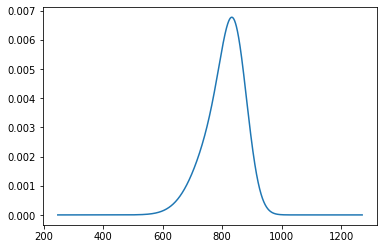

Mean for short: 809.0869476150397
Standard deviation for short: 65.67980760174596


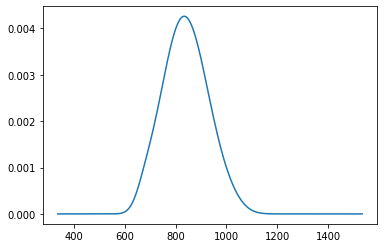

Mean for medium: 839.0043753778564
Standard deviation for medium: 91.38405383325505


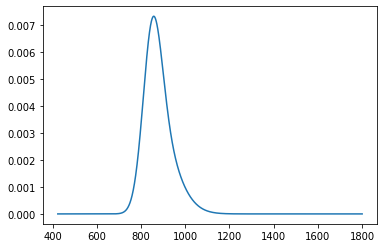

Mean for long: 876.7796740577605
Standard deviation for long: 63.521941134265894


In [3]:
w_s = 0.1
w_m = 0.05
s_star = 847.

a = np.array((494, 671, 847))
b = np.array((847,1023,1200))
label = ('short','medium','long')

Nx = 2**11+1
Ns = 2**11+1

def compute_map_1d(s_grid, prior_pdf, likelihood):
    protoposterior = prior_pdf * likelihood
    max_index = np.argmax(protoposterior, axis=0)
    return s_grid[max_index].reshape((1, Nx))

for i in range(a.size):
    # define the grid
    lb = a[i] - (w_s*a[i])*5.
    ub = b[i] + (w_s*b[i])*5.
    x_row = np.linspace(lb, ub, Nx).reshape((1,Nx)) # make x a row vector
    s_hyp_col = np.linspace(lb, ub, Ns).reshape((Ns,1)) # make s a column vector
    dx = x_row.flatten()[1] - x_row.flatten()[0]
    
    # Compute s_hat for each x
    prior_pdf = sps.uniform.pdf(s_hyp_col, a[i], b[i]-a[i])
    likelihood = sps.norm.pdf(x_row, s_hyp_col, w_s*s_hyp_col)
    s_hat_row = compute_map_1d(s_hyp_col, prior_pdf, likelihood)
    
    r_grid = np.linspace(lb, ub, Nx).reshape((Nx, 1))
    motor_noise = sps.norm.pdf(r_grid, s_hat_row, w_m*s_hat_row)
    
    measure_distribution = sps.norm.pdf(x_row, s_star, w_s*s_star)
    p_response = sp.integrate.romb(motor_noise*measure_distribution, dx=dx, axis=1)
    
    plt.plot(x_row.flatten(), p_response)
    plt.show()
    
    dist_mean = sp.integrate.romb(x_row.flatten()*p_response, dx=dx)
    dist_std = np.sqrt(sp.integrate.romb((x_row.flatten() - dist_mean)**2 * p_response, dx=dx))
    
    print(f"Mean for {label[i]}: {dist_mean}")
    print(f"Standard deviation for {label[i]}: {dist_std}")

# Question 2.3 (6 pts)

> The key quantity for model fitting is the log-likelihood for a dataset and some model parameters. In this exercise, we compute the log-likelihood for a Bayesian observer model which also includes the possibility of *lapses*, a common mechanism used in cognitive science to explain away "random" responses and subjects' mistakes.

In this question, we consider the datasets from Experiment 3 of \[**AWV12**\]. The experimental setup which involves time perception and interval reproduction is very similar to \[**JS10**\], so we can consider the same type of models.

We analyze the data with the `gaussianobserverwithlapse` model, defines as follows:

- We assume the observer builds a (mismatched) Gaussian prior $p(s) = \mathcal{N}\left(s| \mu_\text{prior}, \sigma_\text{prior}^2 \right)$ over the stimuli (time intervals). 
- We assume that the measurement distribution and likelihood are also Gaussian, $p(x|s) = \mathcal{N}\left(x| s, \sigma^2 \right)$.
- The observer uses the *posterior mean* estimator for the value of the stimulus, $\hat{s}_\text{PM}$.
- Gaussian motor response noise is added to the estimate, $p(r|\hat{s}) = \mathcal{N}\left(r| \hat{s}, \sigma_\text{motor}^2 \right)$.
- In each trial, the observer lapses with probability $\lambda$ (the *lapse rate*), in which case the response is drawn from $p_\text{lapse}(r) = \text{Uniform}\left(r; 0, 1500 \right)$ ms. Otherwise, the observer responds normally (according to $p(r|\hat{s})$ described above) with probability $1 - \lambda$. 
- The parameters of this model are $\mathbf{\theta} = \left(\mu_\text{prior}, \sigma_\text{prior}, \sigma, \sigma_\text{motor}, \lambda \right)$.

For this question, we consider parameters $\mathbf{\theta}_\star = \left(\mu_\text{prior} = 780, \sigma_\text{prior} = 140, \sigma = 90, \sigma_\text{motor} = 60, \lambda = 0.02 \right)$. 

- a) Compute the log-likelihood of model parameter $\theta_\star$ for the dataset of subject 2.
- b) Compute the log-likelihood of model parameter $\theta_\star$ for the dataset of subject 5.

Report your results on Moodle with high precision.

*Hint*:
- If you use code from the lectures, be careful about the model definition, as there may be subtle differences.

In [4]:
# Load data of Experiment 3 of [AWV12] from .csv file to a Pandas dataframe
df = pd.read_csv('https://www2.helsinki.fi/sites/default/files/atoms/files/awv12_exp3.csv')

# Remove unused columns (they deal with performance feedback, which we ignore in this lecture)
df.drop(df.columns[[6, 7, 8]], axis=1, inplace=True)

# Remove rows with NaNs
df.dropna(axis=0, inplace=True)

df.head()

,Subject id,Session id,Run id,Stimulus (ms),Response (ms),Stimulus id
0,1,1,1,973.327049,862.947945,6.0
1,1,1,1,677.519900,574.920276,2.0
2,1,1,1,826.253049,870.995615,4.0
3,1,1,1,677.854859,695.055098,2.0
4,1,1,1,598.501198,632.981845,1.0


s.shape: (2520,)
r.shape: (2520,)


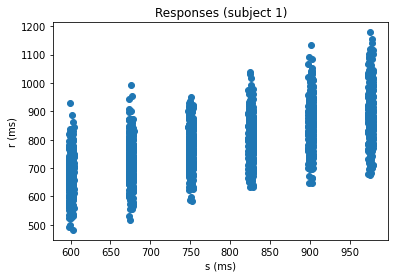

In [5]:
# Example code to extract stimuli and responses for a single subject (here subject 1)
subject = 1
s = np.array(df['Stimulus (ms)'][df['Subject id'] == subject])
r = np.array(df['Response (ms)'][df['Subject id'] == subject])
print('s.shape:', s.shape)
print('r.shape:', r.shape)

plt.scatter(s, r)
plt.xlabel('s (ms)')
plt.ylabel('r (ms)')
plt.title('Responses (subject ' + str(subject) + ')')
plt.show()

In [6]:
theta_star = np.array([780, 140, 90, 60, 0.02])

subject2 = (np.array(df['Stimulus (ms)'][df['Subject id'] == 2]), np.array(df['Response (ms)'][df['Subject id'] == 2]))
subject5 = (np.array(df['Stimulus (ms)'][df['Subject id'] == 5]), np.array(df['Response (ms)'][df['Subject id'] == 5]))

def gaussian_response(s,theta):
    """Compute mean and standard deviation of p(r|s; theta)."""
    # Unpack parameter vector theta
    mu_prior = theta[0]
    sigma_prior = theta[1]
    sigma = theta[2]
    sigma_motor = theta[3]
    # Compute mean and std of the response
    w = sigma_prior**2/(sigma_prior**2 + sigma**2)    
    mu_resp = w*s + (1-w)*mu_prior
    sigma_resp = np.sqrt(w**2*sigma**2 + sigma_motor**2)
    return mu_resp, sigma_resp

def idealgaussianobserverwithlapse_loglike(theta, s_vec, r_vec):
    """Log-likelihood of ideal Gaussian observer with added lapse."""
    mu_prior = theta[0]
    sigma_prior = theta[1]
    sigma = theta[2]
    sigma_motor = theta[3]
    lapse_rate = theta[4]
    
    # log-pdf for the chance of a lapse
    lapse_pdf = sps.uniform.logpdf(r_vec, 0, 1500) + np.log(lapse_rate)
    mu_resp, sigma_resp = gaussian_response(s_vec,np.array((mu_prior,sigma_prior,sigma,sigma_motor)))
    
    # log-pdf of a normal response
    loglike_vec = np.log(1-lapse_rate) + sps.norm.logpdf(r_vec,mu_resp,sigma_resp) # Vector of log-likelihood per trials
    
    # Setting up the terms for a log-sum-exp
    terms = [loglike_vec, lapse_pdf]
    lse_result = sp.special.logsumexp(terms, axis=0)
    
    return np.sum(lse_result)

print(f"Log-likelihood of subject 2: {idealgaussianobserverwithlapse_loglike(theta_star, subject2[0], subject2[1])}")
print(f"Log-likelihood of subject 5: {idealgaussianobserverwithlapse_loglike(theta_star, subject5[0], subject5[1])}")

Log-likelihood of subject 2: -8577.318546123512
Log-likelihood of subject 5: -9105.655523964238


# Question 2.4 (6 pts)

> When fitting models to data, the experimenter may be interested in how model parameters are represented across the population (here represented by the group of subjects). A simple way to look at this is to look at the distribution of maximum-likelihood estimates for the parameters across subjects, in first instance by looking their mean and variability.

We consider here the `idealgaussianobserverwithlapse` model. This model is the same as the `gaussianobserverwithlapse` of Question 2.3, but with $\mu_\text{prior} = 787.5$ ms and $\sigma_\text{prior} = 128.1$ ms fixed. Thus, the model has three free parameters, $\theta = \left(\sigma, \sigma_\text{motor}, \lambda \right)$. Fit the model using maximum-likelihood estimation.

- a) First, fit the `idealgaussianobserverwithlapse` model to the six subjects' datasets (separately for each subject's data). For each maximum-likelihood estimate (MLE) of parameters $\sigma, \sigma_\text{motor}, \lambda$, report in Moodle the mean and standard deviation across the six subjects. For the standard deviation, use the correction for degrees of freedom (that is, `np.std(..., ddof=1)`).
- b) Now fit the pooled data of all subjects as a single dataset (as if all data were collected from a single uber-subject). Report the maximum-likelihood estimate of $\sigma, \sigma_\text{motor}, \lambda$ for the pooled data in Moodle.

*Hints*: 
- If you use code for the `idealgaussianobserverwithlapse` model from the lectures, be careful about the model definition.
- As a sanity check that you have coded the log-likelihood function correctly, check that the log-likelihood of the dataset of subject 1 for $\theta_\star = \left(\sigma = 90, \sigma_\text{motor} = 80, \lambda = 0.02\right)$ is $\log \mathcal{L}(\theta_\star; \mathcal{D}_1) \approx -14709.795\ldots$

*Note*: Fitting individual subjects' data is the best approach to describe invidual behavior in cognitive science, but sometimes you will see studies only looking at pooled/group data. Be careful that pooling might hide what really happens, only giving a snapshot of the average behavior of the group, which might not correspond to what individuals do.

In [7]:
theta_star = np.array([90, 80, 0.02])

def idealgaussianobserverwithlapse_loglike_ex4(theta, s_vec, r_vec):
    """Log-likelihood of ideal Gaussian observer with added lapse."""
    mu_prior = 787.5
    sigma_prior = 128.1
    
    sigma = theta[0]
    sigma_motor = theta[1]
    lapse_rate = theta[2]
    
    # log-pdf for the chance of a lapse
    lapse_pdf = sps.uniform.logpdf(r_vec, 0, 1500) + np.log(lapse_rate)
    mu_resp, sigma_resp = gaussian_response(s_vec,np.array((mu_prior,sigma_prior,sigma,sigma_motor)))
    
    # log-pdf of a normal response
    loglike_vec = np.log(1-lapse_rate) + sps.norm.logpdf(r_vec,mu_resp,sigma_resp) # Vector of log-likelihood per trials
    
    # Setting up the terms for a log-sum-exp
    terms = [loglike_vec, lapse_pdf]
    lse_result = sp.special.logsumexp(terms, axis=0)
    
    return np.sum(lse_result)

def multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,args,num_runs=3):
    """Simple function for multi-start optimization."""
    # Run num_runs optimization runs from different starting points    
    num_params = lower_bounds.shape[0]
    theta_res = np.zeros((num_runs,num_params))
    nll_res = np.zeros(num_runs)    
    
    for index in range(num_runs):
        if index == 0:
            theta0 = 0.5*(plausible_lower_bounds + plausible_upper_bounds)
        else:
            theta0 = np.random.uniform(low=plausible_lower_bounds,high=plausible_upper_bounds)    
        bounds = sp.optimize.Bounds(lower_bounds,upper_bounds,True) # Set hard bounds
        res = sp.optimize.minimize(target_fun, theta0, args=args, method='L-BFGS-B', bounds=bounds)
        nll_res[index] = res.fun
        theta_res[index] = res.x
        print('Run {}: log-likelihood {}'.format(index, -res.fun))
        
    # Pick the best solution
    idx_best = np.argmin(nll_res)
    nll_best = nll_res[idx_best]
    theta_best = theta_res[idx_best]        
    return nll_best,theta_best

lower_bounds = np.array([1., 1., 1e-10])
upper_bounds = np.array([1000., 1000., 1-1e-10])

def calc_plausible_bounds(s_vec):
    lower = np.array([np.mean(s)*0.05, np.mean(s)*0.05, 0.01])
    upper = np.array([np.mean(s)*0.20, np.mean(s)*0.20, 0.05])
    return lower, upper

target_fun = lambda theta, args: -idealgaussianobserverwithlapse_loglike_ex4(theta, *args)

# Load data of Experiment 3 of [AWV12] from .csv file to a Pandas dataframe
df = pd.read_csv('https://www2.helsinki.fi/sites/default/files/atoms/files/awv12_exp3.csv')

# Remove unused columns (they deal with performance feedback, which we ignore in this lecture)
df.drop(df.columns[[6, 7, 8]], axis=1, inplace=True)

# Remove rows with NaNs
df.dropna(axis=0, inplace=True)

res = pd.DataFrame(columns=['sigma','sigma motor','lapse rate'])

for i in range(1,7):
    s = np.array(df['Stimulus (ms)'][df['Subject id'] == i])
    r = np.array(df['Response (ms)'][df['Subject id'] == i])
    lower_plaus, upper_plaus = calc_plausible_bounds(s)
    mle = multioptimize(target_fun,lower_bounds,upper_bounds,lower_plaus,upper_plaus,[s,r])
    
    subject = {
        'sigma': [mle[1][0]],
        'sigma motor': [mle[1][1]],
        'lapse rate': [mle[1][2]]
    }
    res = pd.concat([res, pd.DataFrame(subject)], ignore_index=True)

res.describe()

Run 0: log-likelihood -14497.354655953091
Run 1: log-likelihood -14497.354655862975
Run 2: log-likelihood -14497.354655819316
Run 0: log-likelihood -8422.260464983825
Run 1: log-likelihood -8422.260465187606
Run 2: log-likelihood -8422.260464964704
Run 0: log-likelihood -9190.376741137916
Run 1: log-likelihood -9184.66832287471
Run 2: log-likelihood -9184.72618471038
Run 0: log-likelihood -9293.77866097094
Run 1: log-likelihood -9293.778660622294
Run 2: log-likelihood -9294.942955088525
Run 0: log-likelihood -9084.224657283075
Run 1: log-likelihood -9084.224657354953
Run 2: log-likelihood -9084.224657096569
Run 0: log-likelihood -9107.775502013536
Run 1: log-likelihood -9107.757201119199
Run 2: log-likelihood -9107.75720040816


,sigma,sigma motor,lapse rate
count,6.000000,6.000000,6.000000e+00
mean,98.592944,64.462595,5.600459e-03
std,29.240536,22.915395,5.067878e-03
min,63.395922,30.880898,1.000000e-10
25%,75.101149,49.900250,1.261970e-03
50%,101.746547,72.622609,6.122764e-03
75%,114.338183,75.659146,8.029198e-03
max,139.913901,91.651997,1.305085e-02


In [8]:
print(np.std(res['sigma'], ddof=1))
print(np.std(res['sigma motor'], ddof=1))
print(np.std(res['lapse rate'], ddof=1))

29.24053609664375
22.915394833043266
0.005067878254136901


In [9]:
s = np.array(df['Stimulus (ms)'])
r = np.array(df['Response (ms)'])
lower_plaus, upper_plaus = calc_plausible_bounds(s)
best = multioptimize(target_fun,lower_bounds,upper_bounds,lower_plaus,upper_plaus,[s,r])

print(best)

Run 0: log-likelihood -60047.02425215741
Run 1: log-likelihood -60044.811662391956
Run 2: log-likelihood -60044.811668410824
(60044.811662391956, array([9.80949382e+01, 6.41166686e+01, 7.63904501e-03]))
